<a href="https://colab.research.google.com/github/dolmani38/Summary/blob/master/reinforce_based_summarization_v0.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DO_ALL = True # 전체 실행하면서 시간 걸리는 걸 Pass 하려면 이걸 False ...
## print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
USE_PRETRAINED_MODEL = True # 이미 학습한 모델을 사용하려면.. true

In [2]:
if DO_ALL:
    !pip install sentence-transformers==0.3.0
    !pip install transformers==3.0.2
    !pip install wikipedia
    !pip install konlpy

In [3]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout,Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential, model_from_json
from tensorflow.python.framework import tensor_shape
import keras.utils as ku 

# set seeds for reproducability
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

from konlpy.tag import Okt

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    return txt 

In [5]:
# load ascii text and covert to lowercase

def get_sample_text(target_url):
    raw_text = urllib.request.urlopen(target_url).read().decode('utf-8')
    return nltk.sent_tokenize(clean_text(raw_text))

In [6]:
ko_sentences_dataset = []

ko_sentences_dataset += get_sample_text("https://raw.githubusercontent.com/dolmani38/Summary/master/data/korean_sample.txt")
# 여기서 계속 수집...
ko_sentences_dataset += get_sample_text("https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-ABC%20%EC%82%B4%EC%9D%B8%EC%82%AC%EA%B1%B4.txt")

ko_sentences_dataset += get_sample_text("https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EA%B7%B8%EB%A6%AC%EA%B3%A0%20%EC%95%84%EB%AC%B4%EB%8F%84%20%EC%97%86%EC%97%88%EB%8B%A4.txt")

In [7]:
len(ko_sentences_dataset)

54730

In [8]:
ko_sentences_dataset[50002]

'그러나 올리버 부인이라는 사람도 미스 올턴이라는 여자도 만난 적은 없어요.'

In [9]:

# false 문장을 만들기 위해 shffle 함수 준비
import random

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

# true 문장, false 문장의 생성
ko_grammar_dataset = []
for txt in ko_sentences_dataset:
    txt = txt.strip()
    if len(txt) > 40:
        #ko_grammar_dataset.append([txt,1])
        txt = txt.replace('.','')
        ko_grammar_dataset.append([txt,1]) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
        ko_grammar_dataset.append([shuffling(txt),0])
    
# dataset을 전체적으로 다시 썩는다.
random.shuffle(ko_grammar_dataset)

In [10]:
ko_grammar_dataset[11]

['변했다 핏물로 기병은 말발굽에 한줌 틸라크 말에서 일순간에 떨어진 울부짖는 적아의', 0]

In [11]:
okt = Okt()

# 형태소 Code table의 구성

_MAX_MORP_LENGTH = 128
_PADDING_CODE = 0  # padding code
_MISMATCH_CODE = 1 # mismatch word code               ex) @@@
_MISMATCH_WORD = '@@@' # 이거 아래에서 쓴다.

morpheme_table = {}
morp_code = _MISMATCH_CODE+1
morpheme_table['Pad'] = _PADDING_CODE 
morpheme_table['Mst'] = _MISMATCH_CODE 
'''
 Pad               0
 Mst               1
 Noun              2
 Punctuation       3
 Foreign           4
 Josa              5
 Verb              6
 Modifier          7
 Adjective         8
 Suffix            9
 Adverb            10
 Number            11
 Alpha             12
 Determiner        13
 Conjunction       14
 Exclamation       15
 KoreanParticle    16
 URL               17
 VerbPrefix        18
 Eomi              19
 Hashtag           20
 PreEomi           21
'''
morpheme_table['Noun']=2
morpheme_table['Punctuation']=3
morpheme_table['Foreign']=4
morpheme_table['Josa']=5
morpheme_table['Verb']=6
morpheme_table['Modifier']=7
morpheme_table['Adjective']=8
morpheme_table['Suffix']=9
morpheme_table['Adverb']=10
morpheme_table['Number']=11
morpheme_table['Alpha']=12
morpheme_table['Determiner']=13
morpheme_table['Conjunction']=14
morpheme_table['Exclamation']=15
morpheme_table['KoreanParticle']=16
morpheme_table['URL']=17
morpheme_table['VerbPrefix']=18
morpheme_table['Eomi']=19
morpheme_table['Hashtag']=20
morpheme_table['PreEomi']=21
morpheme_table['Email']=22

In [12]:

print('Korean morpheme code table')
print('----------------------------------------------------------')
print('  Morpheme        Code')
print('')
for morp in morpheme_table.keys():
    print(f' {morp.ljust(15)}   {morpheme_table[morp]}')
print('----------------------------------------------------------')

Korean morpheme code table
----------------------------------------------------------
  Morpheme        Code

 Pad               0
 Mst               1
 Noun              2
 Punctuation       3
 Foreign           4
 Josa              5
 Verb              6
 Modifier          7
 Adjective         8
 Suffix            9
 Adverb            10
 Number            11
 Alpha             12
 Determiner        13
 Conjunction       14
 Exclamation       15
 KoreanParticle    16
 URL               17
 VerbPrefix        18
 Eomi              19
 Hashtag           20
 PreEomi           21
 Email             22
----------------------------------------------------------


In [13]:

# morpheme 코드 변환기 준비
def morpheme_encode(sentence):
    encode=[]
    morphemes = okt.pos(sentence)
    x = np.zeros((_MAX_MORP_LENGTH, len(morpheme_table)), dtype=np.bool)
    for i, (word,morp) in enumerate(morphemes):
        if i < _MAX_MORP_LENGTH:
            code = _MISMATCH_CODE if word==_MISMATCH_WORD else morpheme_table[morp]
            x[i,code] = 1.0   
    return x

ko_morpheme_x = []
ko_morpheme_y = []

if USE_PRETRAINED_MODEL:
    ko_morpheme_x = np.load('ko_morpheme_x.npy')
    ko_morpheme_y = np.load('ko_morpheme_y.npy')
    print('dataset load from file.')
else:
    #true / false 문장을 morpheme 코드로 모두 변환
    tc = len(ko_grammar_dataset)

    for i, (txt,label) in enumerate(ko_grammar_dataset):
        print(f'\r {i+1}/{tc}', end="", flush=True)
        ko_morpheme_x.append(morpheme_encode(txt))
        ko_morpheme_y.append([label])

    ko_morpheme_x = np.asarray(ko_morpheme_x)
    ko_morpheme_y = np.asarray(ko_morpheme_y)
    np.save('ko_morpheme_x',ko_morpheme_x)
    np.save('ko_morpheme_y',ko_morpheme_y)


dataset load from file.


In [14]:

from sklearn.model_selection import train_test_split
# 20%를 testset으로 사용.,,
X_train, X_test, y_train, y_test = train_test_split(ko_morpheme_x,ko_morpheme_y,test_size=0.2)

print(f'Shape of X_train;{X_train.shape}')
print(f'Shape of X_test ;{X_test.shape}')
print(f'Shape of y_train;{y_train.shape}')
print(f'Shape of y_test ;{y_test.shape}')

Shape of X_train;(26468, 128, 23)
Shape of X_test ;(6618, 128, 23)
Shape of y_train;(26468, 1)
Shape of y_test ;(6618, 1)


In [15]:
from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

In [16]:
if USE_PRETRAINED_MODEL:
    model_json_url = "https://raw.githubusercontent.com/dolmani38/Summary/master/models/morpheme_model.json"
    model_weight_url = "https://github.com/dolmani38/Summary/blob/master/models/morpheme_model.h5?raw=true"
    loaded_model_json = urllib.request.urlopen(model_json_url).read().decode('utf-8')
    morpheme_model = model_from_json(loaded_model_json)
    urllib.request.urlretrieve(model_weight_url, "morpheme_model.h5")
    morpheme_model.load_weights("morpheme_model.h5")
    morpheme_model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[r2])
    print('Use pretrained model...')
else:
    # model build
    morpheme_model = Sequential()
    morpheme_model.add(Conv1D(filters=256, kernel_size=4, padding='same',activation='relu',input_shape=(_MAX_MORP_LENGTH, len(morpheme_table))))
    morpheme_model.add(MaxPooling1D(pool_size=2))
    morpheme_model.add(Conv1D(filters=128, kernel_size=4, padding="same",activation='relu'))
    morpheme_model.add(MaxPooling1D(pool_size=2))
    morpheme_model.add(Flatten())
    morpheme_model.add(Dense(128))
    morpheme_model.add(Dense(1, activation='linear'))
    morpheme_model.summary() #Print model Summary

    morpheme_model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[r2])
    hist = morpheme_model.fit(X_train, y_train, epochs=30)

Use pretrained model...


In [17]:

# 학습결과 확인

results = morpheme_model.evaluate(X_test, y_test)
print('mean_squared_error:',results)

# 학습 결과의 확인
predicts = morpheme_model.predict(X_test)
predicts = np.asarray(predicts)
predicts = [ 1 if x>0.5 else 0 for [x] in predicts]
y = np.asarray(y_test)
y = y.reshape(y.shape[0],)

from sklearn.metrics import classification_report
print(classification_report(y, predicts))

207/207 [==============================] - 8s 4ms/step - loss: 0.1427 - r2: 0.4137
mean_squared_error: [0.14861345291137695, 0.38426852226257324]
              precision    recall  f1-score   support

           0       0.92      0.75      0.82      3327
           1       0.78      0.93      0.85      3291

    accuracy                           0.84      6618
   macro avg       0.85      0.84      0.84      6618
weighted avg       0.85      0.84      0.84      6618



In [18]:
if USE_PRETRAINED_MODEL:
    pass
else:
    model_json = morpheme_model.to_json()
    with open("morpheme_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    print("save network to morpheme_model.json")

    morpheme_model.save_weights("morpheme_model.h5")
    print("save weights to morpheme_model.h5")

In [19]:
def morpheme_discriminator(queries):
    # queries : 복수의 문장의 2차원 배열 (None,1)
    # return : 결과 score 배열 (None,)
    x_codes = []
    for query in queries:
        x_codes.append(morpheme_encode(query))
    scores = morpheme_model.predict(np.array(x_codes))
    return scores #1.0 if scores > 0.5 else 0.0 

In [20]:
morpheme_discriminator([' 무럭무럭 자라서, 아기는 소녀가 예쁘고 마음씨 고운 되었어요'])

array([[0.20912042]], dtype=float32)

In [80]:
org_text = """나무꾼이 나무를 하다가 숲 속에서 도망치는 사슴을 만났는데, 이 사슴이 사냥꾼이 쫓아오고 있으니 자신을 숨겨달라고 말했다. 말하는 사슴을 신기하게 여긴 나무꾼이 사슴을 숨겨줬고, 뒤쫓아 온 사냥꾼을 다른 방향으로 보내서 구해주었다.
사슴은 은혜를 갚겠다고 하면서, 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 샘과 선녀들이 목욕을 하러 오는 시기, 선녀의 옷을 훔쳐 그를 아내로 삼도록 하는 꾀를 나무꾼에게 가르쳐 주었다. 나무꾼은 반신반의 하면서도 사슴이 가르쳐준 시기에 선녀들이 목욕을 하러 내려온다는 샘으로 찾아가 몸을 숨겼다. 그렇게 잠시간 기다리자 과연, 선녀들이 하늘에서 내려와 날개옷을 벗고 선녀탕에서 목욕을 하는 것이었다. 나무꾼은 사슴이 가르쳐준 대로 날개옷을 하나 훔쳤다.
날개옷이 없어진 탓에 한 명의 선녀는 하늘로 올라가지 못했으며 다른 선녀들은 날개옷이 없는 선녀를 내버려두고 하늘로 돌아갔다. 이때 나무꾼이 홀로 남은 선녀에게 자신의 아내가 되어달라고 하자, 하늘나라로 올라가지 못하게 된 선녀는 할 수 없이 나무꾼에게 의탁하게 되었다.
"""

In [21]:
org_text = """옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 후 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.
해도 해도 끝이 없는 집안일이 힘들어 지칠때면
난롯가에 앉아서 잠시 쉬곤 했지요.
"엄마, 저애를 신데렐라라고 불러야겠어요."
"온통 재투성이잖아요. 호호호!" 두 언니는 소녀를 놀려 댔어요.
어느 날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
"신데렐라, 너도 무도회에 가고 싶니?"
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
"내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴."
마법사 할머니가 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.
신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.
"신데렐라, 발을 내밀어 보거라."
할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.
"신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?"
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
땡, 땡, 땡...... 벽시계가 열두 시를 알리는 소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데,
유리 구두 한 짝이 벗겨졌어요.
하지만 구두를 주울 틈이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리 구두 한 짝을 주웠어요.
왕자님은 유리 구두를 가지고 임금님께 가서 말했어요.
"이 유리 구두의 주인과 결혼하겠어요."
그래서 신하들은 유리 구두의 주인을 찾아 온 나라를 돌아다녔어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리 구두는 너무 작았어요.
그때, 신데렐라가 조용히 다가와 말했어요.
"저도 한번 신어 볼 수 있나요?"
신데렐라는 신하게 건넨 유리 구두를 신었어요,
유리 구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요."""

In [81]:
org_text = clean_text(org_text).strip()
org_text

'나무꾼이 나무를 하다가 숲 속에서 도망치는 사슴을 만났는데 이 사슴이 사냥꾼이 쫓아오고 있으니 자신을 숨겨달라고 말했다. 말하는 사슴을 신기하게 여긴 나무꾼이 사슴을 숨겨줬고 뒤쫓아 온 사냥꾼을 다른 방향으로 보내서 구해주었다. 사슴은 은혜를 갚겠다고 하면서 나무꾼에게 선녀들이 하늘에서 내려와서 목욕하는 선녀탕이라는 샘과 선녀들이 목욕을 하러 오는 시기 선녀의 옷을 훔쳐 그를 아내로 삼도록 하는 꾀를 나무꾼에게 가르쳐 주었다. 나무꾼은 반신반의 하면서도 사슴이 가르쳐준 시기에 선녀들이 목욕을 하러 내려온다는 샘으로 찾아가 몸을 숨겼다. 그렇게 잠시간 기다리자 과연 선녀들이 하늘에서 내려와 날개옷을 벗고 선녀탕에서 목욕을 하는 것이었다. 나무꾼은 사슴이 가르쳐준 대로 날개옷을 하나 훔쳤다. 날개옷이 없어진 탓에 한 명의 선녀는 하늘로 올라가지 못했으며 다른 선녀들은 날개옷이 없는 선녀를 내버려두고 하늘로 돌아갔다. 이때 나무꾼이 홀로 남은 선녀에게 자신의 아내가 되어달라고 하자 하늘나라로 올라가지 못하게 된 선녀는 할 수 없이 나무꾼에게 의탁하게 되었다.'

In [23]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer

if DO_ALL:
    # embedder download...
    embedder = SentenceTransformer('xlm-r-large-en-ko-nli-ststb')

In [24]:
# 생성된 문장의 원문 유사도를 측정하기 위한 함수

import scipy
#print(doc_emb)
def similarity_discriminator(queries,org_embedding):
    # queries : 복수의 문장의 2차원 배열 (None,1)
    # org_embedding : 비교 대상의 원문 embedding 1차원 배열 (1,)
    # return : 결과 score 배열 (None,)
    total_score = 0
    query_embeddings = embedder.encode(queries,show_progress_bar=False)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], [org_embedding], "cosine")[0]
        results = zip(range(len(distances)), distances)
        for idx, distance in results:
            total_score += 1-distance
    return total_score

In [82]:

# 원문의 embedding...
org_text_emb = embedder.encode([org_text],show_progress_bar=False)[0]
org_text_emb

array([ 0.37110198, -0.19225626, -0.25144747, ..., -0.17844155,
        0.41148975,  0.53386396], dtype=float32)

In [83]:
org_term_set = (' ' + org_text + ' ').split(' ')

_MAX_GEN_TOKEN = 40
_NOISE_DIM = len(org_term_set)

word_table = {}
morp_table = {}

for index, word in zip(range(len(org_term_set)),org_term_set):
    word_table[index] = word
    m = okt.pos(word)
    morp_table[index] = m[0][1] if len(m) > 0 else ''
    
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token         Morp')
print('')
for k in word_table.keys():
  print( f'  {str(k).ljust(8)}    {word_table[k]}       {morp_table[k]}')
print('---------------------------------------------')

Token table of origin text
---------------------------------------------
 Code         Token         Morp

  0                  
  1           나무꾼이       Noun
  2           나무를       Noun
  3           하다가       Verb
  4           숲       Noun
  5           속에서       Noun
  6           도망치는       Verb
  7           사슴을       Noun
  8           만났는데       Verb
  9           이       Noun
  10          사슴이       Noun
  11          사냥꾼이       Noun
  12          쫓아오고       Verb
  13          있으니       Adjective
  14          자신을       Noun
  15          숨겨달라고       Verb
  16          말했다.       Noun
  17          말하는       Noun
  18          사슴을       Noun
  19          신기하게       Adjective
  20          여긴       Verb
  21          나무꾼이       Noun
  22          사슴을       Noun
  23          숨겨줬고       Verb
  24          뒤쫓아       Noun
  25          온       Noun
  26          사냥꾼을       Noun
  27          다른       Noun
  28          방향으로       Noun
  29          보내서       Verb
  30          구

In [27]:
sota_text = """소녀의 언니들은 심술쟁이들 이었어요. 소녀는 집안일을 도맡아 했어요. 신데렐라도 무도회에 가고 싶었어요. 
마법사 할머니가 주문을 외웠어요. 황금 마차로 드레스로 바뀌웠어요. 밤 열두시가 되면 처음대로 돌아간단다. 
왕자님도 신데렐라에게 마음을 빼았겼어요. 벽시계가 열두 시를 알리는 소리에 놀랐어요. 유리 구두 벗겨졌어요. 
왕자님은 주인을 찾아 돌아다녔어요. 구두는 신데렐라의 발에 맞았어요."""

In [28]:
print('Similarity of sota:',similarity_discriminator([sota_text],org_text_emb))

Similarity of sota: 0.5623786453438347


In [29]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))

        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
        # Print New Line on Complete
        if self.ite == self.total: 
            print()

In [100]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram


# weight 들의 초기화
terms = np.array(list(word_table.values()))

story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]) # ,[0,1,2,3,4],[0,2,4,6]])#,[0,2],[0,2,4],[0,2,4,6],[0,2,4,6,8]])
word_filters=np.array([[0]])

story_weights = np.zeros(_NOISE_DIM,)
word_weights = np.zeros(_NOISE_DIM,)

#filters=np.array([[0,2],[0,2,4],[0,2,4,6],[0,2,4,6,8]])
#filters=np.array([[0,1,2,3,4,5]])
terms = np.array(list(word_table.values()))
morps = np.array(list(morp_table.values()))

# story에 지배적인 word를 찾는다.

# 먼저 word의 강세 분석
for filter in word_filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    pb = ProgressBar(last_idx,prefix='word density scan :')
    for conv in range(last_idx,0,-1):
        pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        '''
        w = terms[t][0]
        if w.endswith('.'):  # '.'으로 끝나는 동사 - '술어' 는 대부분 스토리상중요한 내용 포함. 하여... 이건 제외 단어에서 skip시킴
            score = 0.0
        else:
            #part_sen = ' '.join(terms[t]) 
            #score = similarity_discriminator([part_sen],org_text_emb)
            score = similarity_discriminator([w],org_text_emb)
        '''

        if morps[t][0] in ('Adjective ','Adverb','Conjunction'):
            pass
        else:
            part_sen = ' '.join(terms[t]) 
            score = similarity_discriminator(part_sen.strip(),org_text_emb)
            word_weights[t] += score
        
# story의 강세 분석
for filter in story_filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    pb = ProgressBar(last_idx,prefix='story density scan:')
    for conv in range(last_idx,0,-1):
        pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        part_sen = ' '.join(terms[t]) 
        score = similarity_discriminator([part_sen],org_text_emb)
        story_weights[t] += score

#각각의 peak를 산출
word_peaks, _ = find_peaks(word_weights, height=0)
story_peaks, _ = find_peaks(story_weights, height=0)

#두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
#해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
#이를 통해 story에 대한 word를 최대한 추출 한다.

dup_order = []
for i in range(_NOISE_DIM):
    #lst = ""
    if (i in word_peaks) and (i in story_peaks):
        if terms[i].endswith('.'):
            pass
        else:
            dup_order.append(i)
# Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
print('Negative words:',terms[dup_order])
terms[dup_order] = '---'
'''
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token      ')
print('')
for index, word in zip(range(len(terms)),terms):
    print( f'  {str(index).ljust(8)}    {word}')
print('---------------------------------------------')
'''
story_weights = np.zeros(_NOISE_DIM,)
# 그리고 다시 story 분석 스캔
for filter in story_filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    pb = ProgressBar(last_idx,prefix='story density scan:')
    for conv in range(last_idx):
        pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        part_sen = ' '.join(terms[t]) 
        #part_sen = part_sen.replace('소녀','---')
        score = similarity_discriminator([part_sen],org_text_emb)
        story_weights[t] += score

word density scan : |||||||||||||||||||||| 100.0%   filer:[0] 1/129       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 1/128       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 1/127       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 1/126       
Negative words: ['사슴을' '사슴을' '사슴을' '사슴은' '나무꾼에게' '훔쳐' '나무꾼에게' '사슴이' '벗고' '사슴이' '나무꾼이'
 '나무꾼에게']
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1] 127/128       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2] 126/127       
story density scan: |||||||||||||||||||||| 100.0%   filer:[0, 1, 2, 3] 125/126       


[  4  11  21  24  26  33  39  43  47  51  58  65  71  76  78  85  93 102
 105 114 120 128]


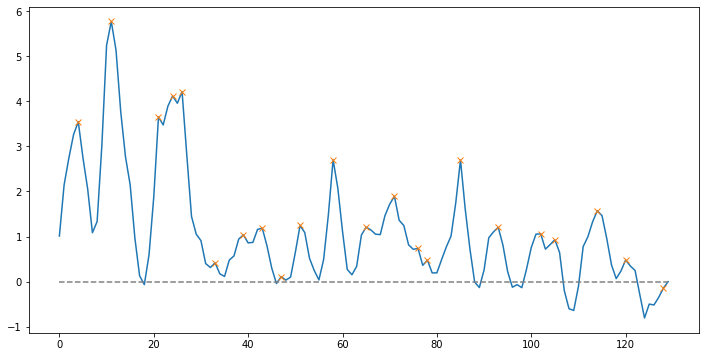

Peak count: 22


In [107]:

# base line
base_line = 0.0
# 다시 peak 추출
story_peaks, _ = find_peaks(story_weights, height=base_line)
story_peaks = np.append(story_peaks,len(story_weights)-2)
print(story_peaks)
# story density 표출
plt.figure(figsize=(12, 6))
plt.plot(story_weights)
plt.plot(story_peaks, story_weights[story_peaks], "x")
plt.plot(np.zeros_like(story_weights)+base_line, "--", color="gray")
plt.show() 
print('Peak count:',len(story_peaks))

In [108]:

# story skeleton 추출
skel_text = ""
for k in story_peaks:
    #print(k,term_weight[k],word_table[k])
    skel_text += word_table[k]+' '  

print(skel_text)
print('')
print(f'Peak count:{len(story_peaks)}   Similarity : {similarity_discriminator([skel_text],org_text_emb)}')

숲 사냥꾼이 나무꾼이 뒤쫓아 사냥꾼을 갚겠다고 목욕하는 목욕을 선녀의 아내로 나무꾼은 목욕을 숨겼다. 선녀들이 내려와 나무꾼은 없어진 선녀들은 선녀를 자신의 못하게 되었다. 

Peak count:22   Similarity : 0.7400025289317711


In [109]:
for index, word in zip(range(len(org_term_set)),org_term_set):
    word_table[index] = word
    
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token              Score')
print('')
for k in word_table.keys(): 
  print( f'  {str(k).ljust(8)}    {word_table[k].ljust(10)}    {story_weights[k]}')
print('---------------------------------------------')

Token table of origin text
---------------------------------------------
 Code         Token              Score

  0                         1.0105617673969496
  1           나무꾼이          2.1435749298001454
  2           나무를           2.7355104794818104
  3           하다가           3.257948956335863
  4           숲             3.545386846508379
  5           속에서           2.7415858723774837
  6           도망치는          2.0499202646325805
  7           사슴을           1.0844162143697529
  8           만났는데          1.3335253490589603
  9           이             3.017028709479995
  10          사슴이           5.237668029209363
  11          사냥꾼이          5.767665511471762
  12          쫓아오고          5.131361933675175
  13          있으니           3.768357779161742
  14          자신을           2.773769383758024
  15          숨겨달라고         2.1454399040106695
  16          말했다.          0.9635126667428264
  17          말하는           0.1297303766730702
  18          사슴을           -0.06641453160310384


In [78]:

# text의 생성
def text_gen(noise, term_length):
    gtext = []
    sorted_noise = np.sort(noise)[::-1]
    order = np.where(noise > sorted_noise[term_length+1])[0][-term_length:]
    assert len(order) == term_length
    for k in order:
        gtext.append((word_table[k],k))
        #text += word_table[k]+' '    
    return gtext 

Train... |||||||||||||||||||||| 100.0%   5000/5000 epochs, m_score:1.1507176160812378 s_score:0.8347366241403736 속에서 만났는데 사슴이 사냥꾼이 있으니 자신을 숨겨달라고 말했다. 사슴을 신기하게 나무꾼이 뒤쫓아 사냥꾼을 구해주었다. 은혜를 갚겠다고 선녀들이 하늘에서 목욕하는 목욕을 선녀의 아내로 나무꾼은 하면서도 가르쳐준 목욕을 하러 내려온다는 숨겼다. 그렇게 기다리자 선녀들이 하늘에서 내려와 선녀탕에서 나무꾼은 가르쳐준 없어진 한 선녀는 선녀들은 없는 선녀를 되었다.                                            


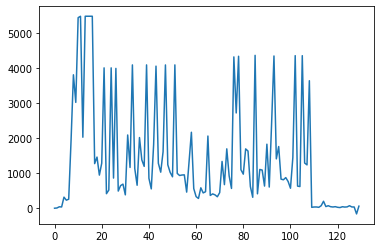

result text :  만났는데 이 사슴이 사냥꾼이 쫓아오고 있으니 자신을 숨겨달라고 말했다. 사슴을 나무꾼이 뒤쫓아 사냥꾼을 사슴은 갚겠다고 선녀들이 하늘에서 목욕하는 선녀들이 목욕을 시기 선녀의 아내로 주었다. 나무꾼은 목욕을 숨겼다. 잠시간 선녀들이 하늘에서 내려와 선녀탕에서 목욕을 나무꾼은 하나 날개옷이 없어진 탓에 한 다른 선녀들은 선녀를 내버려두고 돌아갔다.
result score :  0.8545003183331901
skel_text :  숲 사냥꾼이 나무꾼이 뒤쫓아 사냥꾼을 갚겠다고 목욕하는 목욕을 선녀의 아내로 나무꾼은 목욕을 숨겼다. 선녀들이 내려와 나무꾼은 없어진 선녀들은 선녀를 자신의 못하게 되었다. 


In [114]:
term_weight = np.zeros(_NOISE_DIM,)

verbose = False
p_score = 0
scale = 50
epochs = 5000
sum_length = len(story_peaks) + int(len(story_peaks)*1.0)
pb = ProgressBar(epochs/scale,prefix='Train...')
count = 1
for epoch in range(epochs):
    noise = np.random.rand(_NOISE_DIM,)
    # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
    noise[story_peaks] += np.mean(noise) / 2
    noise += term_weight / count
    gtext = text_gen(noise,sum_length)
    #print(' '.join([w for (w,k) in gtext]))
    #print([k for (w,k) in gtext])    
    # 문장 단위로 잘라서 문법 체크...
    total_score = []
    tw = ""
    tk = []
    for (w,k) in gtext:
        tw += w + ' '
        tk.append(k)
        if w.endswith('.'):
            # morpheme_discriminator
            #print(tk)
            score = morpheme_discriminator([tw])[0]
            if verbose:
                print(f'score:{score} text:{tw}')
            term_weight[tk] += score
            total_score.append(score)
            tw = ""
            tk = []
            
    if len(tk) > 0:
        # morpheme_discriminator
        #print(tw)
        #print(tk)        
        score = morpheme_discriminator([tw])[0]
        if verbose:
            print(f'score:{score} text:{tw}')
        term_weight[tk] += score
        total_score.append(score)
        tw = ""
        tk = []        
            
    #term_weight[order] += score
    '''
    reward = p_score - score
    if (p_score ==0):
        pass
    else:
        term_weight[order] += reward
    p_score = score
    '''
    text = ' '.join([w for (w,k) in gtext])

    score = similarity_discriminator([text],org_text_emb)

    reward = p_score - score
    if (p_score ==0):
        pass
    else:
        term_weight[order] += reward
    s_score = score

    count += 1
    if epoch%scale == 0:
        pb.printProgress(+1,f'{epoch+scale}/{epochs} epochs, m_score:{np.mean(total_score)} s_score:{score} {text}                                            ')

        
#plt.plot(term_weight)
plt.plot(term_weight)
plt.show()
gtext = text_gen(term_weight,sum_length)
text = ' '.join([w for (w,k) in gtext])
score = similarity_discriminator([text],org_text_emb)
print('result text : ',text)
print('result score : ',score)
print('skel_text : ',skel_text)